<br />

<div style="text-align: left;">
<font size="7">Car Fuel Consumption</font>
</div>
<br />
<div style="text-align: right;">
<font size="4">Minoru katsuta ml_tokyo_9 2018-2019</font>
</div>

<br />

## 課題設定　100kmあたりのガソリン消費量を予測

#### ＜Context＞
- どんな要素がガソリンを消費するのかを予測してほしい
- SP98,E10のガソリンの種類に応じて消費量を予測してほしい

- 線形回帰モデルを試行したところ、E10では0.4リットル以上消費していた
- 線形回帰モデルは特徴量が独立している場合にしか使用できない欠点があることに留意

#### ＜Content＞
- このデータには、以下のデータが含まれている
- distance:車のディスプレイに表示される距離（km）
- consume:消費量（L/100km）
- speed:平均速度（km/h）
- temp_inside:内部温度(℃)
- temp_outside:外部温度（℃）
- specials:乗車中に以下の３つの特別なことがあった場合
- AC:エアコンをつけていた
- rain:雨が降っていた場合
- sun:天候が晴れで車のエンジンをスタートする際に温かく感じたとき
- gas_type:E10,SP98の2種類のいずれかを使用
- refill liters:どのくらいガソリンを給油したのか
- refill gas:どの種類のガソリンを給油したのか

### 1．データセットの読み込みとデータ内容の確認

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,Lasso,ElasticNet #正則化項付き最小二乗法を行うためのライブラリ
import seaborn as sns

from sklearn.model_selection import train_test_split # ホールドアウト法の関数
from sklearn.model_selection import KFold # 交差検証法の関数
# 回帰問題におけるＭＡＥ（平均絶対値誤差）,ＭＳＥ（平均２乗和誤差）を算出する関数
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [2]:
df_ms1 = pd.read_csv("../1_data/measurements.csv") #CSVFileを読み込む pandasの関数}
display(df_ms1.head()) #datasetの先頭5行を表示
df_ms1.describe(include = 'all')

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
2,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
3,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
4,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN


,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
count,388,388,388.000000,376,388.000000,93,388,388.000000,388.000000,388.000000,13,13
unique,174,43,NaN,13,NaN,12,2,NaN,NaN,NaN,10,2
top,"11,8",5,NaN,"21,5",NaN,rain,SP98,NaN,NaN,NaN,45,SP98
freq,37,27,NaN,133,NaN,32,228,NaN,NaN,NaN,2,8
mean,NaN,NaN,41.927835,NaN,11.358247,NaN,NaN,0.077320,0.123711,0.082474,NaN,NaN
std,NaN,NaN,13.598524,NaN,6.991542,NaN,NaN,0.267443,0.329677,0.275441,NaN,NaN
min,NaN,NaN,14.000000,NaN,-5.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,32.750000,NaN,7.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,40.500000,NaN,10.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN
75%,NaN,NaN,50.000000,NaN,16.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN


In [3]:
df_ms1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
distance         388 non-null object
consume          388 non-null object
speed            388 non-null int64
temp_inside      376 non-null object
temp_outside     388 non-null int64
specials         93 non-null object
gas_type         388 non-null object
AC               388 non-null int64
rain             388 non-null int64
sun              388 non-null int64
refill liters    13 non-null object
refill gas       13 non-null object
dtypes: int64(5), object(7)
memory usage: 36.5+ KB


### 2．前処理
（１）データクレンジング

* 欠損値を含めデータを削除する。 temp_inside
* 量的変数であるべきデータの小数点がカンマとなっているため、データ補正を行う
* ガスタイプのエンコーディング

In [4]:
# temp_inside 欠損値を含むデータを削除する
df_ms1 = df_ms1.dropna(subset=['temp_inside'])

In [5]:
# distance カンマを小数点に補正
df_ms1['distance'] = df_ms1['distance'].apply(lambda x: x.replace(",", "."))
df_ms1['distance'] = df_ms1['distance'].astype(np.float)

In [6]:
# consume カンマを小数点に補正
df_ms1['consume'] = df_ms1['consume'].apply(lambda x: x.replace(",", "."))
df_ms1['consume'] = df_ms1['consume'].astype(np.float)

In [7]:
# temp_inside カンマを小数点に補正
df_ms1['temp_inside'] = df_ms1['temp_inside'].apply(lambda x: x.replace(",", "."))
df_ms1['temp_inside'] = df_ms1['temp_inside'].astype(np.float)


In [8]:
# gas_typeのエンコーディング
df_ms1.loc[df_ms1['gas_type'] == 'E10', 'gas_type']  = 0
df_ms1.loc[df_ms1['gas_type'] == 'SP98', 'gas_type'] = 1 

In [9]:
display(df_ms1.head()) #datasetの先頭5行を表示
df_ms1.describe(include = 'all')

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,0,0,0,0,45,E10
1,12.0,4.2,30,21.5,13,NaN,0,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,0,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,0,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,0,0,0,0,NaN,NaN


,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
count,376.000000,376.000000,376.000000,376.000000,376.000000,91,376.000000,376.000000,376.00000,376.000000,13,13
unique,NaN,NaN,NaN,NaN,NaN,12,NaN,NaN,NaN,NaN,10,2
top,NaN,NaN,NaN,NaN,NaN,rain,NaN,NaN,NaN,NaN,45,SP98
freq,NaN,NaN,NaN,NaN,NaN,31,NaN,NaN,NaN,NaN,2,8
mean,19.797340,4.925266,41.957447,21.929521,11.340426,NaN,0.582447,0.079787,0.12500,0.082447,NaN,NaN
std,22.988878,1.040705,13.714354,1.010455,7.066999,NaN,0.493813,0.271325,0.33116,0.275411,NaN,NaN
min,1.300000,3.300000,14.000000,19.000000,-5.000000,NaN,0.000000,0.000000,0.00000,0.000000,NaN,NaN
25%,11.800000,4.300000,32.000000,21.500000,6.000000,NaN,0.000000,0.000000,0.00000,0.000000,NaN,NaN
50%,14.600000,4.700000,40.500000,22.000000,10.000000,NaN,1.000000,0.000000,0.00000,0.000000,NaN,NaN
75%,19.000000,5.300000,50.000000,22.500000,16.000000,NaN,1.000000,0.000000,0.00000,0.000000,NaN,NaN


In [10]:
df_ms1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 376 entries, 0 to 387
Data columns (total 12 columns):
distance         376 non-null float64
consume          376 non-null float64
speed            376 non-null int64
temp_inside      376 non-null float64
temp_outside     376 non-null int64
specials         91 non-null object
gas_type         376 non-null int64
AC               376 non-null int64
rain             376 non-null int64
sun              376 non-null int64
refill liters    13 non-null object
refill gas       13 non-null object
dtypes: float64(3), int64(6), object(3)
memory usage: 38.2+ KB


### ２．前処理

（２）データ前処理  
 > 標準化・無相関化・白色化等を検討する

In [11]:
# 標準化のために特定のカラムを抽出してデータフレームに格納する
df_ms1_std = df_ms1[["consume", "distance", "speed", "temp_inside", "temp_outside", "gas_type", "AC", "rain","sun"]]

C:\Users\d0054302\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\d0054302\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\d0054302\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

標準化の結果


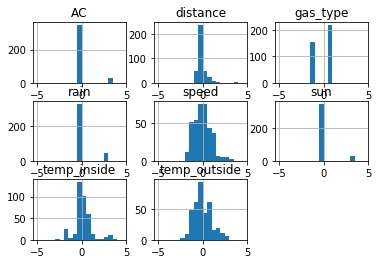

In [12]:
# 標準化を行う
df_ms1_std["distance"] = (df_ms1_std["distance"] - df_ms1_std["distance"].mean()) / df_ms1_std["distance"].std(ddof=0)
df_ms1_std["speed"]    = (df_ms1_std["speed"] - df_ms1_std["speed"].mean()) / df_ms1_std["speed"].std(ddof=0)
df_ms1_std["temp_inside"] = (df_ms1_std["temp_inside"] - df_ms1_std["temp_inside"].mean()) / df_ms1_std["temp_inside"].std(ddof=0)
df_ms1_std["temp_outside"] = (df_ms1_std["temp_outside"] - df_ms1_std["temp_outside"].mean()) / df_ms1_std["temp_outside"].std(ddof=0)
df_ms1_std["gas_type"] = (df_ms1_std["gas_type"] - df_ms1_std["gas_type"].mean()) / df_ms1_std["gas_type"].std(ddof=0)    
df_ms1_std["AC"]       = (df_ms1_std["AC"] - df_ms1_std["AC"].mean()) / df_ms1_std["AC"].std(ddof=0)
df_ms1_std["rain"]     = (df_ms1_std["rain"] - df_ms1_std["rain"].mean()) / df_ms1_std["rain"].std(ddof=0)
df_ms1_std["sun"]      = (df_ms1_std["sun"] - df_ms1_std["sun"].mean()) / df_ms1_std["sun"].std(ddof=0)

df_ms1_std.head()

#標準化の結果
df_ms1_std.iloc[:,1:].hist(bins=np.arange(-5,5,0.5))
print("標準化の結果")
plt.show()

### 今回のターゲット変数であるConsumeと説明変数の関係を確認する  

#### 目的
> １．無相関化の必要有無の確認  
> ２．説明変数の絞り込み

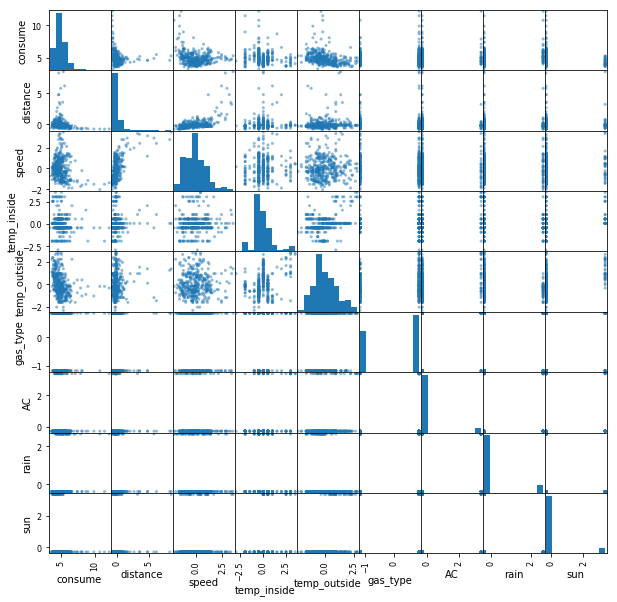

In [13]:
# pandasuを利用して散布図行列を作成する
pd.plotting.scatter_matrix(df_ms1_std, figsize=(10,10))
plt.show()

In [14]:
#ピアソンの積率相関係数を計算
df_ms1_std.corr() 

,consume,distance,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
consume,1.000000,-0.131379,-0.234537,-0.161991,-0.318758,-0.020928,0.093892,0.247699,-0.169173
distance,-0.131379,1.000000,0.565505,0.075305,0.086774,-0.047877,-0.027670,-0.022129,0.078627
speed,-0.234537,0.565505,1.000000,0.059725,0.019327,-0.099495,-0.036351,-0.002936,0.077181
temp_inside,-0.161991,0.075305,0.059725,1.000000,0.361308,0.010340,0.297775,-0.037356,0.246120
temp_outside,-0.318758,0.086774,0.019327,0.361308,1.000000,0.156990,0.169374,-0.185731,0.349988
gas_type,-0.020928,-0.047877,-0.099495,0.010340,0.156990,1.000000,0.109996,0.059112,0.038120
AC,0.093892,-0.027670,-0.036351,0.297775,0.169374,0.109996,1.000000,0.244848,0.090164
rain,0.247699,-0.022129,-0.002936,-0.037356,-0.185731,0.059112,0.244848,1.000000,-0.113298
sun,-0.169173,0.078627,0.077181,0.246120,0.349988,0.038120,0.090164,-0.113298,1.000000


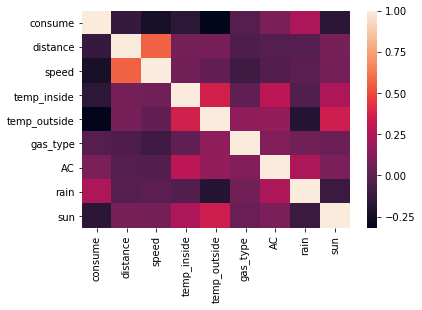

In [15]:
# 相関係数をヒートマップにして可視化
sns.heatmap(df_ms1_std.corr())
plt.show()

### 3. 交差検証（クロスバリデーション）法による汎化誤差評価


In [16]:
def predict(cross_model):

    # ターゲット変数、説明変数を決定する
    y = df_ms1_std["consume"].values
    X = df_ms1_std[["distance", "speed", "temp_inside", "temp_outside", "gas_type", "AC", "rain","sun"]].values
    
    # 何分割でクロスバリデーションを実施するかグループ数を定義する
    n_split = 10
    
    # 回帰問題の評価指標の初期化 MAE（平均絶対値誤差）、MSE（平均２乗和誤差）、RMSE（平方根平均２乗和誤差）
    cross_valid_mae  = 0
    cross_valid_mse  = 0
    cross_valid_rmse = 0
    
    split_num = 1
    
    # テスト役を交代させながら学習と評価を繰り返す
    #scikitlearnのクラス『KFold』を利用して交差検証を行う
    for train_idx, test_idx in KFold(n_splits = n_split, random_state = 1234).split(X, y):
        X_train, y_train = X[train_idx], y[train_idx] #学習用データ
        X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
        
        # 学習用データを使って線形回帰モデルを学習
        #regr = LinearRegression(fit_intercept=False)
        cross_model.fit(X_train, y_train)

        # 重みを取り出す
        w0 = cross_model.intercept_
        w1 = cross_model.coef_[0]
        w2 = cross_model.coef_[1]
        w3 = cross_model.coef_[2]
        w4 = cross_model.coef_[3]
        w5 = cross_model.coef_[4]
        w6 = cross_model.coef_[5]
        w7 = cross_model.coef_[6]
        w8 = cross_model.coef_[7]
        
        #print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}, w7 = {:.3f}, w8 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6, w7, w8))

        # テストデータに対する予測を実行
        y_pred_test = cross_model.predict(X_test)
    
        # テストデータに対するMAEを計算
        mae  = mean_absolute_error(y_test, y_pred_test)  #平均絶対誤差 MAE
        mse  = mean_squared_error(y_test, y_pred_test)   #平均２乗和誤差 MSE
        rmse = rmse = np.sqrt(mse)                       #平方根２乗和誤差 RMSE
        
        #print("Fold %s"%split_num)
        #print("MAE = %s"%round(mae, 3))
        #print("MSE = %s"%round(mse, 3))
        #print("RMSE = %s"%round(rmse, 3))
            
        cross_valid_mae  += mae  #後で平均を取るためにMAEを加算
        cross_valid_mse  += mse  #後で平均を取るためにMSEを加算
        cross_valid_rmse += rmse #後で平均を取るためにRMSEを加算
        split_num += 1

    # 各平均値を最終的な汎化誤差値とする
    final_mae  = cross_valid_mae  / n_split
    final_mse  = cross_valid_mse  / n_split
    final_rmse = cross_valid_rmse / n_split
    print("Cross Validation MAE  = %s"%round(final_mae, 3))
    print("Cross Validation MSE  = %s"%round(final_mse, 3))
    print("Cross Validation RMSE = %s"%round(final_rmse, 3))
    print()

    return


In [17]:
# 線形回帰モデルでクロスバリデーションを実施する

predict(LinearRegression(fit_intercept=False)) 


Cross Validation MAE  = 6.192
Cross Validation MSE  = 41.362
Cross Validation RMSE = 6.353



In [18]:
# リッジ回帰モデルでクロスバリデーションを実施する
alphas = [1.0, 1e-80, 1e-5, 1e-1]#alpha(数式ではλ)の値を4つ指定する
for alpha in alphas:
    print(alpha)
    predict(Ridge(alpha=alpha))
    print()


1.0
Cross Validation MAE  = 0.644
Cross Validation MSE  = 0.926
Cross Validation RMSE = 0.917


1e-80
Cross Validation MAE  = 0.644
Cross Validation MSE  = 0.927
Cross Validation RMSE = 0.917


1e-05
Cross Validation MAE  = 0.644
Cross Validation MSE  = 0.927
Cross Validation RMSE = 0.917


0.1
Cross Validation MAE  = 0.644
Cross Validation MSE  = 0.927
Cross Validation RMSE = 0.917




In [101]:
# ラッソ回帰モデルでクロスバリデーションを実施する
alphas = [1e-20, 1e-3, 1e-2, 1e-1]#alpha(数式ではλ)の値を4つ指定する
for alpha in alphas:
    print(alpha)
    predict(Lasso(alpha=alpha,max_iter=1e7))
    print()


1e-20


C:\Users\d0054302\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\d0054302\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\d0054302\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\d0054302\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\line

Cross Validation MAE  = 0.644
Cross Validation MSE  = 0.927
Cross Validation RMSE = 0.917


0.001
Cross Validation MAE  = 0.644
Cross Validation MSE  = 0.926
Cross Validation RMSE = 0.917


0.01
Cross Validation MAE  = 0.638
Cross Validation MSE  = 0.92
Cross Validation RMSE = 0.913


0.1
Cross Validation MAE  = 0.623
Cross Validation MSE  = 0.931
Cross Validation RMSE = 0.911




C:\Users\d0054302\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [ ]:
# エラスティックネットでクロスバリデーションを実施する
alpha = 1e-4 #正則化全体の強さを決定する
l1_ratios = [0, 0.1, 0.5, 1.0] #L1正則化の強さを4つ指定する（L2正則化の強さは1 - l1_ratioで自動的に設定される）

for l1_ratio in l1_ratios:
    print(l1_ratio)
    predict(ElasticNet(alpha=alpha, l1_ratio = l1_ratio, max_iter = 1e8))
    print()


0
